* При применении свёртки изображение уменьшается на `размер фильтра - 1` по каждой координате (изображение 32 на 32 при применении фильра 3 на 3 уменьшится до изображения 30 на 30).
* При свёртке трехмерных изображений: для каждого канала свой фильтр, каждый обучается сам, затем всё складываем и получаем свёрнутое изображение. Т.е. для изображения с 3 каналами и 3 фильтрами (по 1 на каждый канал) в результате получится изображение с 1 каналом.
* **Страйд** - передвижение с пропусками (страйд 2 - передвижение с шагом 2).
* **Дилейшн** - расширенное применение свёртки (дилейшн 2 - применение свёрки к куску изображение 9 на 9 через (при размере фильтра 3)).
* **Паддинг** - дополнение изображения по краям числами (зерро паддинг - доплнение нулями, рефлекшн паддинг - отражение, репликейшн паддинг - продолжаем значением крайнего пикселя).
* **Пуллинг** - разбиваем изображение на кусочки и по нему вычисляем статистики (среднее или максимум), снижает размер изображения (для пуллинга 2 в 2 раза), увеличивает поле восприятия, нечего обучат.
* **Поле восприятия** - штука, которая показывает от какого кол-ва пикслей исходного изображения зависит пиксель изображения после свёрток. Например для фильтра 3 на 3 после первого слоя поле восприятия 3 на 3, после второго слоя с фильтроми 3 на 3 поле восприятия уже 5 на 5. Поле восприятия больше, если фильтр больше: для фильтра 5 на 5 после 2х слоёв поле восприятия будет 9 на 9. Т.е. с каждым последующим слоем после первого поле восприятия увеличивается на `размер фильтра - 1`.

# Задача 1

Напишите функцию для подсчета количества параметров в сверточном слое. Ваша функция должна принимать на вход количество входных каналов, количество выходных каналов, размер ядра и стоит ли делать обучаемый сдвиг. Сделайте для нее такую сигнатуру: `def count_parameters_conv(in_channels: int, out_channels: int, kernel_size: int, bias: bool):`

In [1]:
def count_parameters_conv(
    in_channels: int, 
    out_channels: int,
    kernel_size: int,
    bias: bool) -> int:
    
    if bias:
        return (in_channels * kernel_size ** 2 + 1) * out_channels
    return (in_channels * kernel_size ** 2) * out_channels

# Задача 2 Обучите свою первую нейронную сеть!

Обучите полносвязную нейронную сеть для классификации на датасете `MNIST`. Добейтесь качества в `98%` на тестовой выборке.


Чтобы мы могли проверить вашу модель, напишите функцию, которая создает вашу модель и возвращает объект, назовите функцию `create_mlp_model`, без аргументов. Вам понадобится сохранить веса вашей модели и сдать их в тестировщик, для этого воспользуйтесь методами `torch.save` и `state_dict`.

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.optim import Adam, Optimizer
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output


def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn) -> float:
    
    model.train()
    total_loss = 0
    
    for x, y in tqdm(data_loader, desc='Train'):
        
        optimizer.zero_grad()
        
        out = model(x)
        loss = loss_fn(out, y)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    
    return total_loss / len(data_loader)


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn) -> tuple[float]:
    
    model.eval()
    total_loss = 0
    total = 0
    correct = 0
    
    for x, y in tqdm(data_loader, desc='Test'):
        
        out = model(x)
        _, model_pred = torch.max(out, 1)
        
        total_loss += loss_fn(out, y).item()
        
        
        total += y.shape[0]
        correct += (model_pred == y).sum().item()
        
    return total_loss, correct / total


def plot_stats(
    train_loss: list,
    valid_loss: list,
    test_metric: list
):
    
    fig = plt.figure(figsize=(10, 7))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.xlabel('Epoch Num')
    plt.legend()
    plt.grid()
    plt.title('Train / Validation Loss')
    plt.show()
    
    fig = plt.figure(figsize=(10, 7))
    plt.plot(test_metric, label='Test Accuracy')
    plt.xlabel('Epoch Num')
    plt.grid()
    plt.title('Test Accuracy')
    plt.show()

In [6]:
def create_mlp_model() -> nn.Module:
    
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=28 * 28 * 1, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=1028),
        nn.ReLU(),
        nn.Linear(in_features=1028, out_features=10)
    )
    
    return net


net = create_mlp_model()
optimizer = Adam(net.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

train_data = MNIST(
    './datasets/MNIST',
    train=True,
    download=True,
    transform=T.ToTensor()
)


test_data = MNIST(
    './datasets/MNIST',
    train=False,
    download=True,
    transform=T.ToTensor()
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

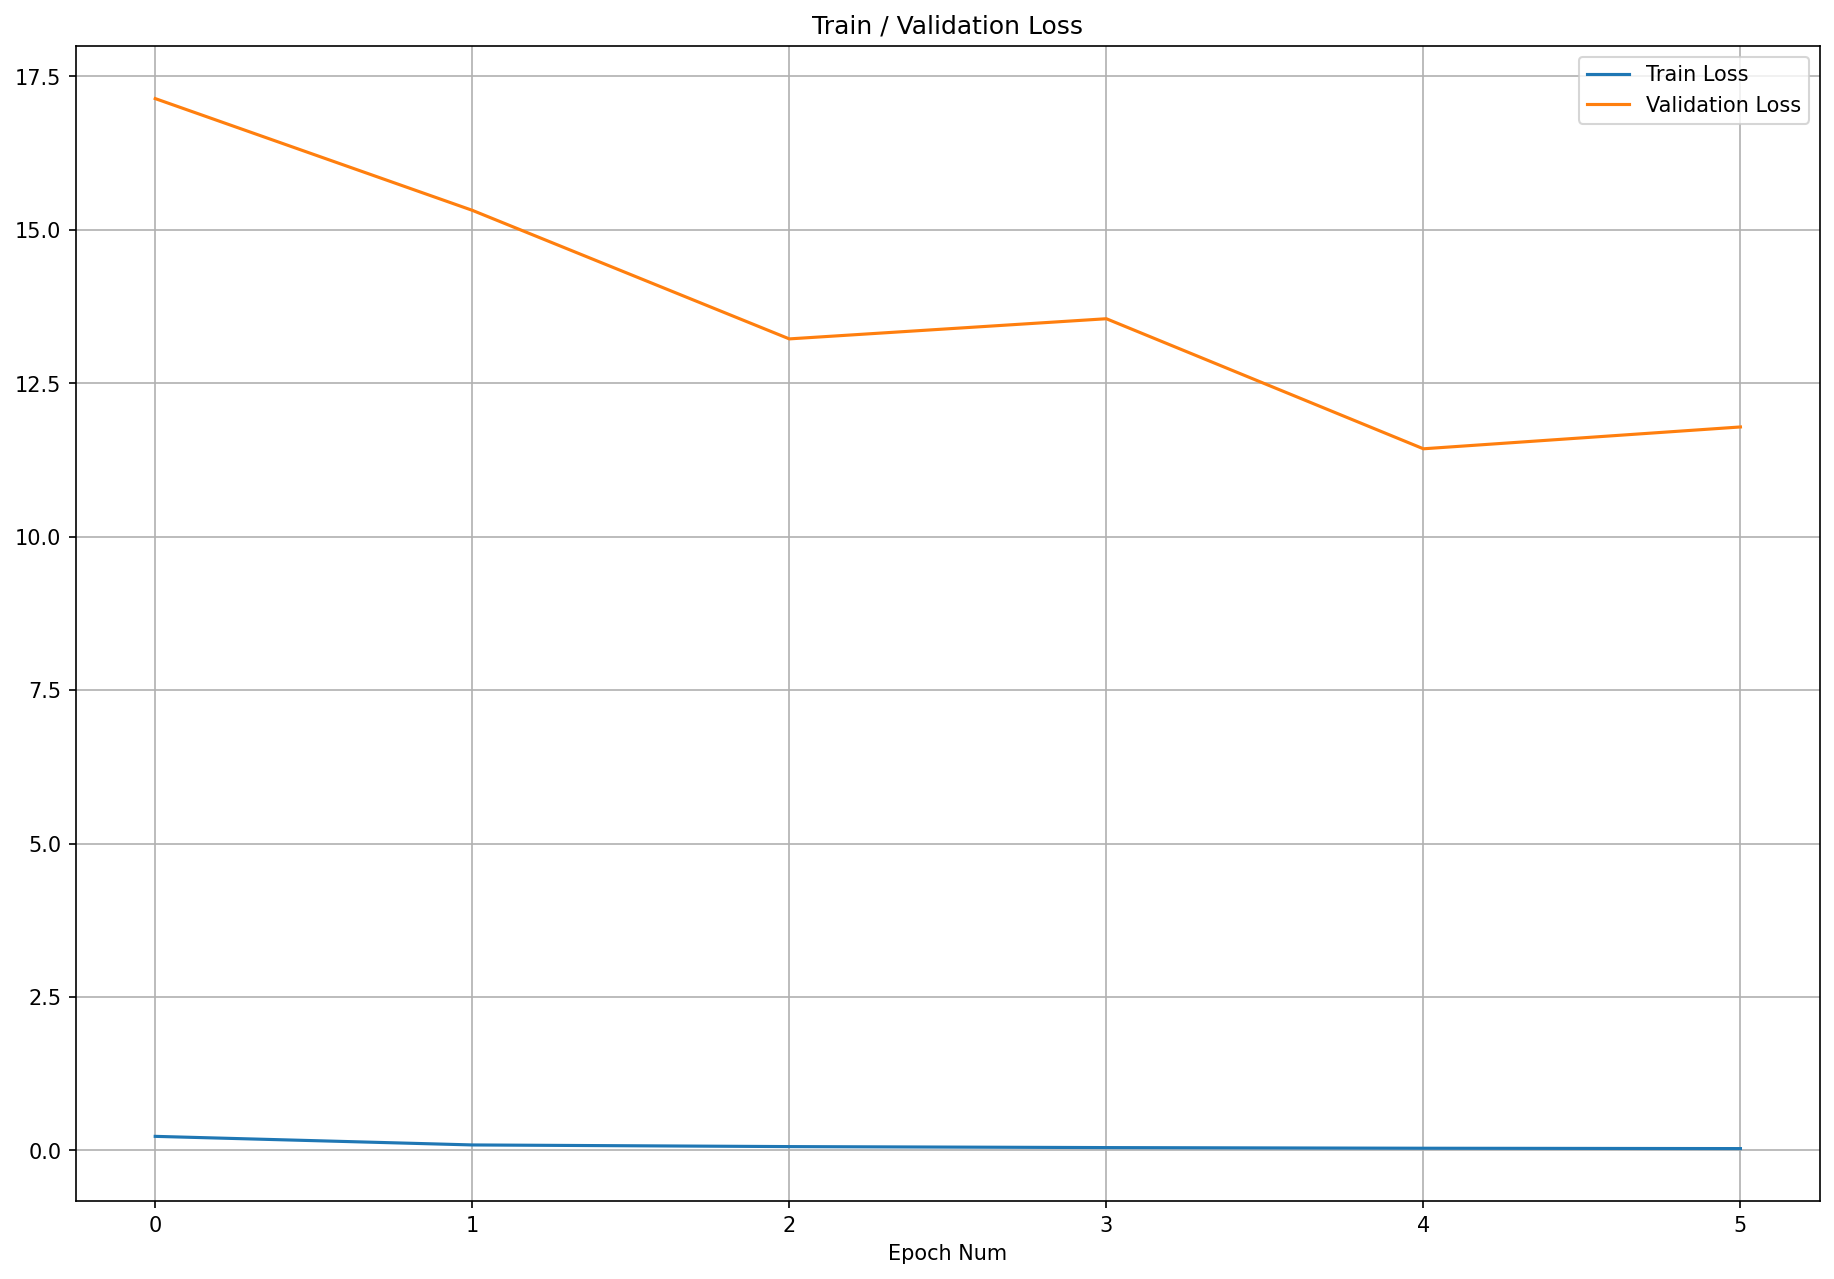

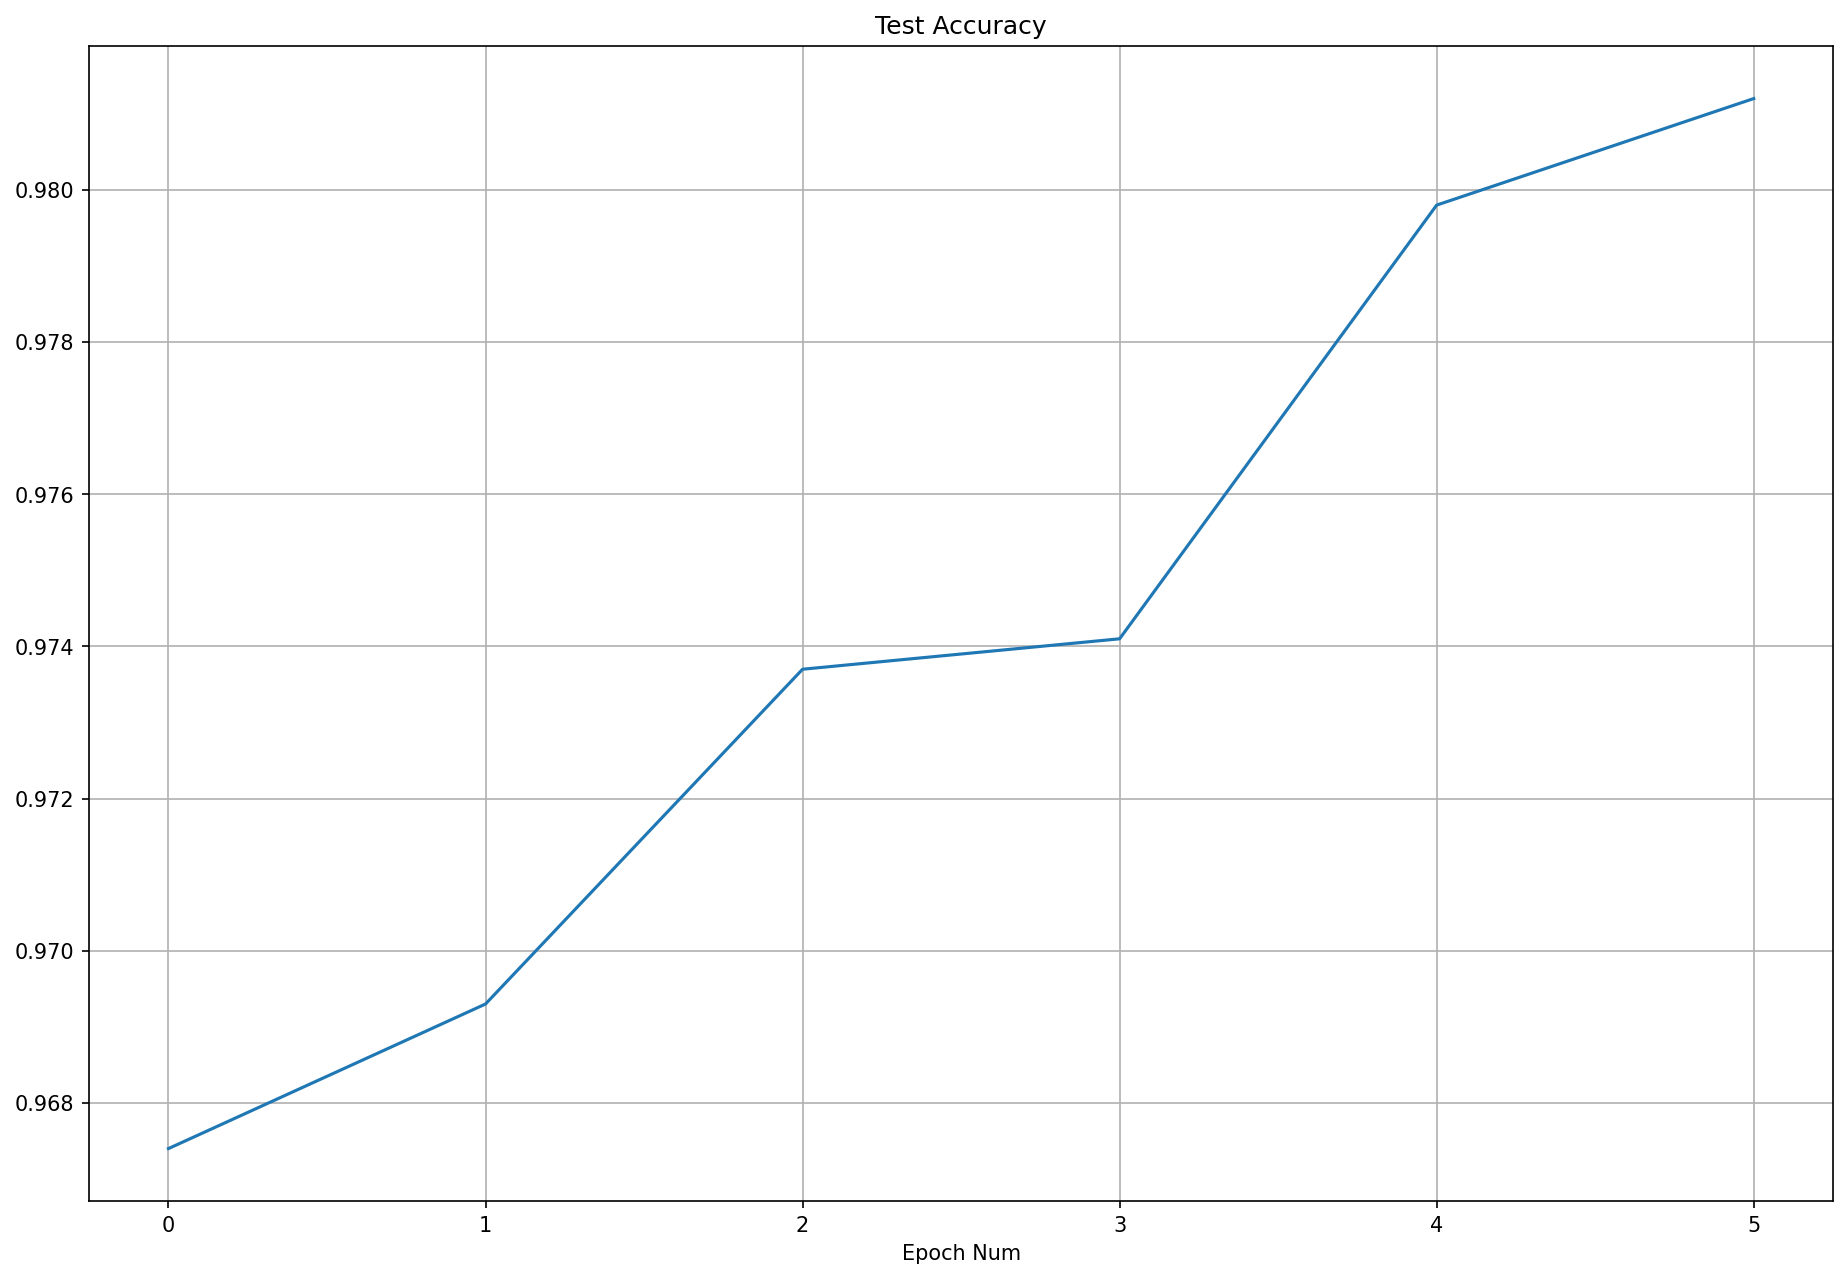

CPU times: user 3min 56s, sys: 2min 26s, total: 6min 22s
Wall time: 1min 9s


In [7]:
%%time

num_epoch = 0
train_loss_list, test_loss_list, accuracy_list = [], [], []

while True:
    train_loss = train(net, train_loader, optimizer, loss)
    test_loss, accuracy = evaluate(net, test_loader, loss)
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    accuracy_list.append(accuracy)
    
    clear_output()
    
    plot_stats(train_loss_list, test_loss_list, accuracy_list)
    
    if accuracy >= 0.98:
        break

In [60]:
torch.save(net.state_dict(), './mlp_model')

# Задание 3

Обучите сверточную нейронную сеть для классификации на датасете MNIST. Добейтесь качества в 99.3% на тестовой выборке.

In [2]:
def create_conv_model():
#     net = nn.Sequential(
#     nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),

#     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
#     nn.ReLU(),
#     nn.MaxPool2d(kernel_size=2),

#     nn.Flatten(),
#     nn.Linear(4 * 4 * 64, 256),
#     nn.ReLU(),
#     nn.Linear(256, 10)
#     )
    
    net = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2), # 32 * 28 * 28
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # 32 * 14 * 14
        
        nn.Conv2d(in_channels=32, out_channels=256, kernel_size=5), # 256 * 10 * 10
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2), # 256 * 5 * 5
        
        nn.Flatten(),
        nn.Linear(in_features=256 * 5 * 5, out_features=1024),
        nn.ReLU(),
        nn.Linear(in_features=1024, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10)
    )
    
    return net

In [3]:
net = create_conv_model()
optimizer = Adam(net.parameters(), lr=1e-3)
loss = nn.CrossEntropyLoss()

train_data = MNIST(
    './datasets/MNIST',
    train=True,
    download=True,
    transform=T.ToTensor()
)


test_data = MNIST(
    './datasets/MNIST',
    train=False,
    download=True,
    transform=T.ToTensor()
)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

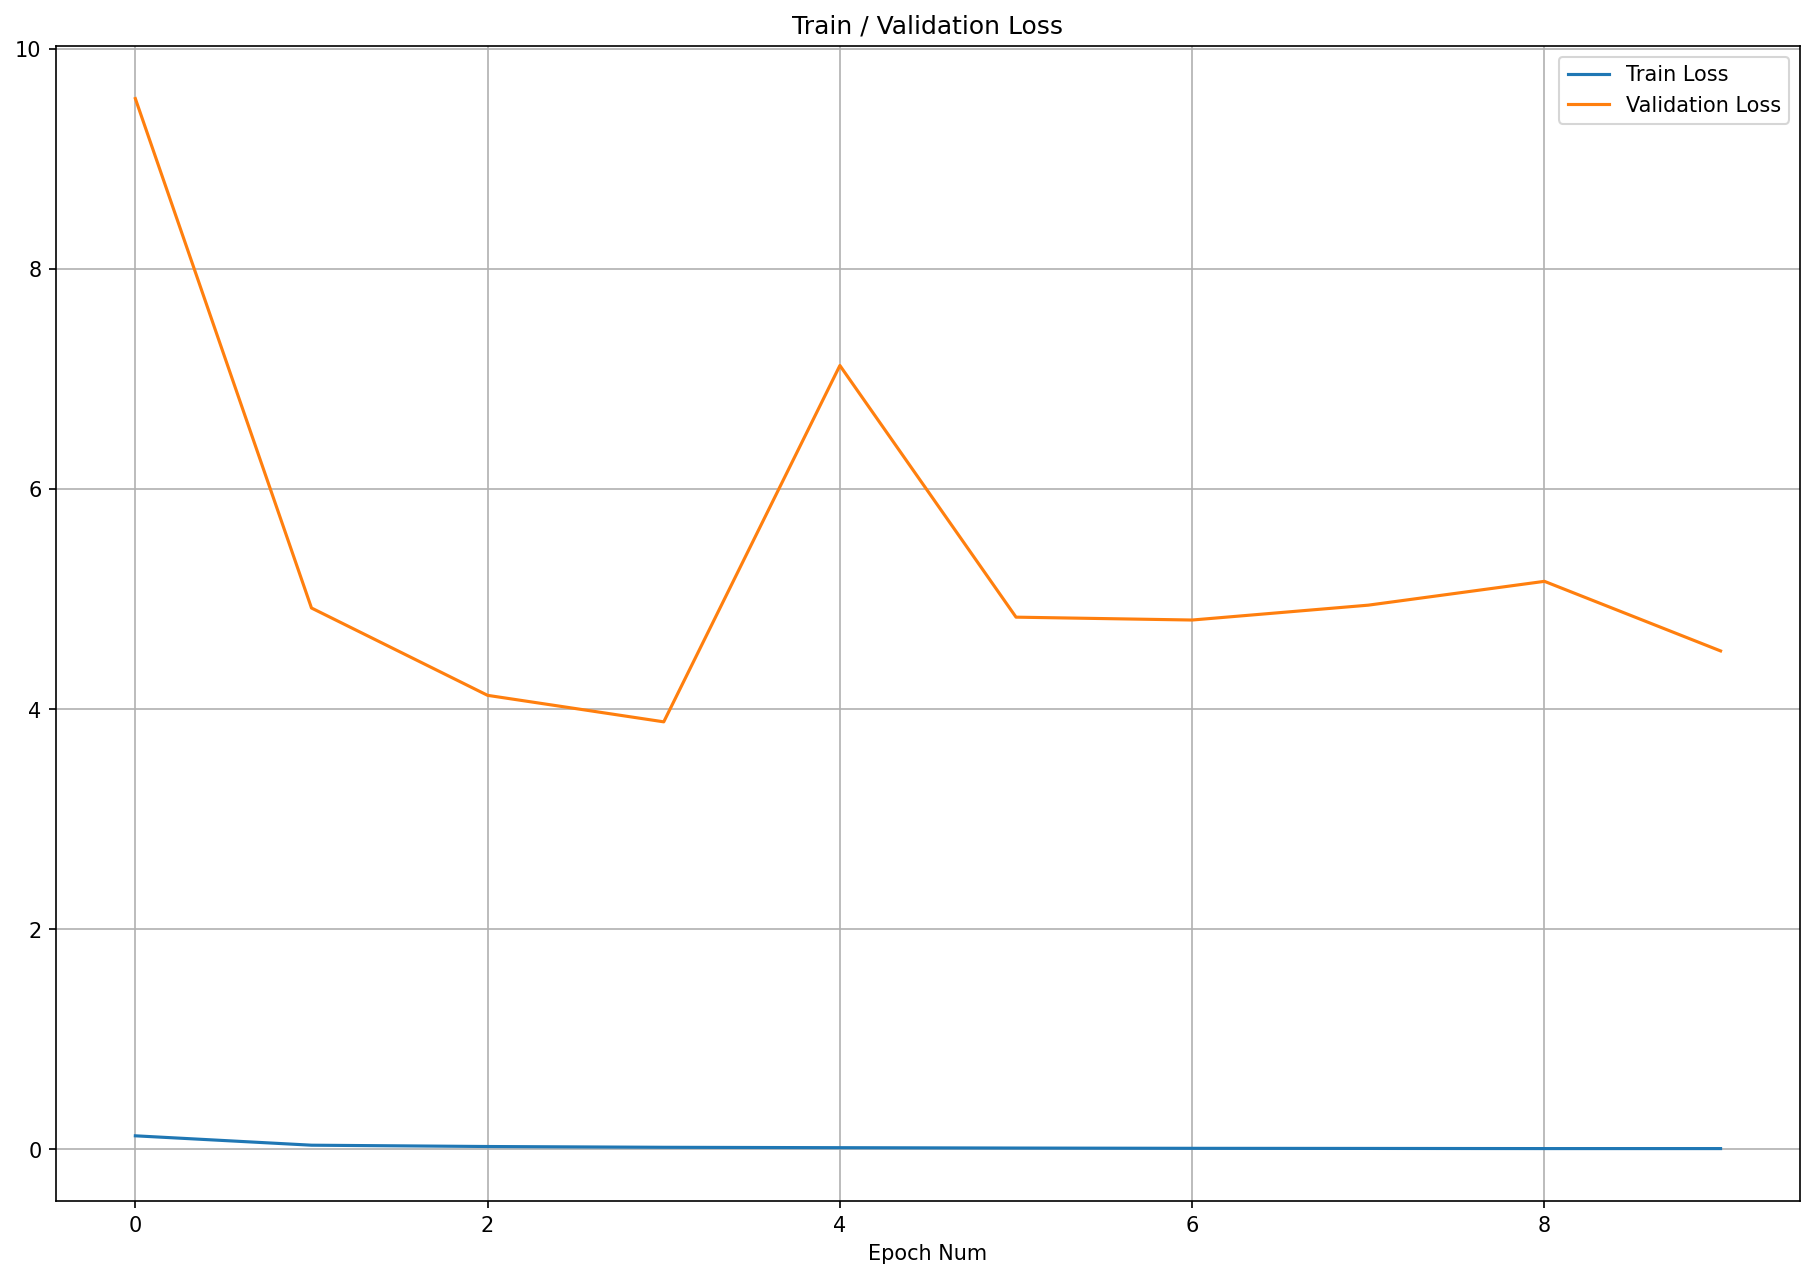

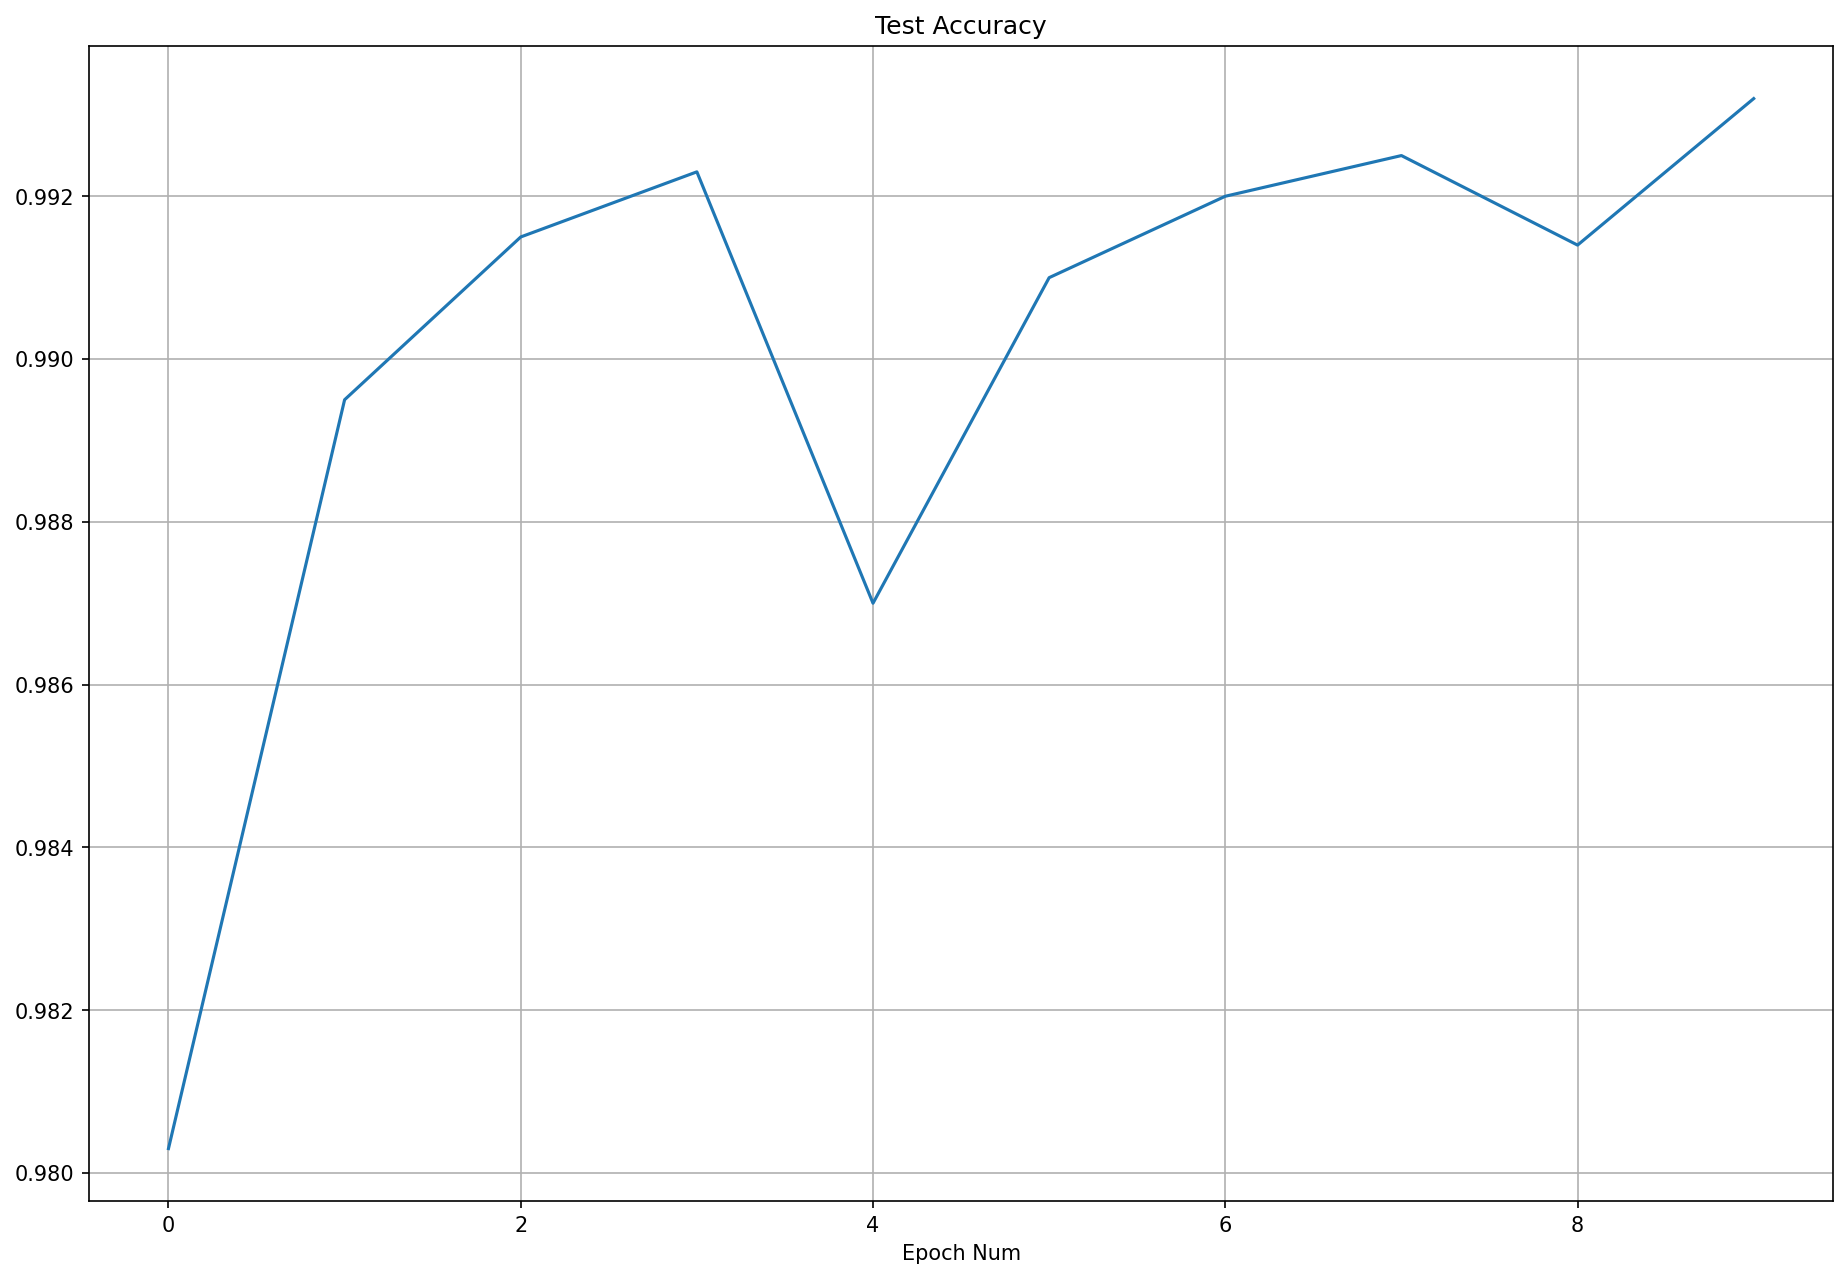

CPU times: user 1h 24min 46s, sys: 26min 27s, total: 1h 51min 13s
Wall time: 16min 24s


In [4]:
%%time

num_epoch = 0
train_loss_list, test_loss_list, accuracy_list = [], [], []

while True:
    train_loss = train(net, train_loader, optimizer, loss)
    test_loss, accuracy = evaluate(net, test_loader, loss)
    
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    accuracy_list.append(accuracy)
    
    clear_output()
    
    plot_stats(train_loss_list, test_loss_list, accuracy_list)
    num_epoch += 1
    if accuracy >= 0.993:
        break

In [5]:
torch.save(net.state_dict(), './conv_model')